In [ ]:
from watpy.coredb.coredb import *
from watpy.wave.wave import *
import h5py
import matplotlib.pyplot as plt

db_path = "./CoRe_DB_clone/"
cdb = CoRe_db(db_path)
sim = cdb.sim

In [ ]:
#how to iterate over all of the runs


print(f"Simulation Name : Run | Simulation data file path | Availible Rh_## waveforms \
: # waveforms : total waveforms | Extraction radii : # of Extraction Radii")

total_rh_waveforms = 0
total_rh_waveform_extraction_radii = 0 

def toggle(inp , ret = "on"):
    if ret or ret == "on":
        return inp

for sim_key in sim:
    sel_sims = sim[sim_key]
    for sim_run in sel_sims.run:

        current_data = sim[sim_key].run[sim_run].data
        current_numpy_array = current_data.read("rh_22")
        current_meta_data = current_data.mdata.data
        # current_h5_file = h5py.File(os.path.join(current_data.path,current_data.dfile),"r")
        # current_rh_waveforms = [i for i in current_h5_file.keys() if i[:2] =='rh']
        # total_rh_waveforms += len(current_rh_waveforms)
        # num_extraction_radii = 0
        # exrad = []
        # for rh_xx in current_rh_waveforms:
        #     num_extraction_radii += len(current_h5_file[rh_xx].keys())  # type: ignore
        #     if True:
        #         fig = plt.figure(figsize=(20,15))
        #         start, end = 0, 4000
        #         print(current_h5_file[rh_xx][list(current_h5_file[rh_xx].keys())[-1]])
            
        #     exrad += current_h5_file[rh_xx].keys()  # type: ignore
        #     break
        # total_rh_waveform_extraction_radii += num_extraction_radii
        # print(f"{sim_key} : {sim_run_key} | {current_data.path}\\{current_data.dfile} | {current_rh_waveforms}: # waveforms: {len(current_rh_waveforms)} : {total_rh_waveforms} | {num_extraction_radii} : {total_rh_waveform_extraction_radii} | {toggle(exrad,'off')}")
        print(current_data,current_meta_data,current_numpy_array)
        break
    break
    


In [ ]:
list_of_selected_attributes = []
for sim_key in sim:
    sel_sims = sim[sim_key]
    # print(sel_sims.md.data)
    for sim_run in sel_sims.run:

        current_data = sim[sim_key].run[sim_run].data
        current_numpy_array = current_data.read("rh_22")
        current_meta_data = current_data.mdata.data
        attr_dict = {"id_eos":current_meta_data["id_eos"].upper(),
                      "m1":current_meta_data["id_mass_starA"],
                      "m2":current_meta_data["id_mass_starB"],
                      "db_key": current_meta_data["database_key"],
                      "r1": -1,
                      "r2": -1
                     }
        list_of_selected_attributes.append(attr_dict)
def sortfunc(x):
    # print(x)
    return x["id_eos"]
list_of_selected_attributes.sort(key=sortfunc)
ordered_by_eos = {}
for i in list_of_selected_attributes:
    # print(i["id_eos"],ordered_by_eos)
    if not ordered_by_eos.get(i["id_eos"].upper(),False):
        ordered_by_eos[i["id_eos"].upper()] = []
        ordered_by_eos[i["id_eos"].upper()].append(i)
    else:
        ordered_by_eos[i["id_eos"].upper()].append(i)


import json
with open("sorted_eos_runs.json","w") as w:
    json.dump(ordered_by_eos, w, indent=4)

In [ ]:
# getting the data of a single run\
sim_name = "THC" + ":" + "0036"
sel_sim = sim[sim_name]
sel_run = sel_sim.run["R01"]
sel_data = sel_run.data
sel_md = sel_run.md.data
# print(sel_md)
for i in sel_md:
    print(f"{i} | {sel_md[i]}")

In [ ]:
current_h5_file = h5py.File(os.path.join(sel_data.path, sel_data.dfile), "r")
print(current_h5_file.keys())
sel_data.show("rh_22")
plt.show()
dset = sel_data.read("rh_22")
fig = plt.plot(dset[:, 0], dset[:, 1])  # gets the real data
plt.show()

In [ ]:
# print(current_h5_file["rh_22"].keys())
npds = current_h5_file["rh_22"]["Rh_l2_m2_rInf.txt"]
# print(npds)
# print(sel_data.mdata.data)
# fig1 = plt.figure(figsize=(20, 15))\

print(len(npds[:,0]),len(npds[:,1]))
plt.plot(
    npds[:, 0]*(4.925*10**-6*float(sel_md["id_mass"])),
    npds[:,1],
)
# fig, ax = sel_data.show("rh_22")
# fig.set_size_inches(20, 15)
# print(npds[:,1],len(npds[:,1]))

In [ ]:
from scipy import signal
from scipy.fft import fftshift
from scipy.cluster.vq import whiten
import matplotlib.pyplot as plt
print(len(npds[:,1]),len(npds[:,0]))
cnpds = npds[:,1]
tsig = npds[:,0]
total_mass_multiplier = (4.925*10**-6*float(sel_md["id_mass"]))




In [ ]:
import pywt
print(pywt.families())
for i in pywt.wavelist(kind="discrete"):
    a,b = pywt.dwt(cnpds,i)
    plt.plot(sorted(a),sorted(b))
    plt.show()

In [ ]:
f, t, Sxx = signal.spectrogram(cnpds,fs = (tsig[-1]-tsig[0])/len(tsig))
plt.pcolormesh(t*total_mass_multiplier, fftshift(f), fftshift(Sxx, axes=0))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
Msun_sec = 4.925794970773135e-06
w = wave(
    path=sel_data.path,
    code="core",
    filename="Rpsi4_l2_m2_r00400.txt",
    mass=float(sel_data.mdata.data["id_rest_mass"]),
    f0=float(sel_data.mdata.data["id_gw_frequency_Hz"]) * Msun_sec,
)
import glob

fnames = [
    os.path.split(x)[1] for x in glob.glob("{}/{}".format(sel_data.path, "Rpsi4_*.txt"))
]
print(fnames)
wm = mwaves(
    path=sel_data.path,
    code="core",
    filenames=fnames,
    mass=float(sel_data.mdata.data["id_rest_mass"]),
    f0=float(sel_data.mdata.data["id_gw_frequency_Hz"]) * Msun_sec,
    ignore_negative_m=True,
)
print(wm.modes)
sel_data.mdata.data["id_gw_frequency_Hz"]

In [68]:

import pandas as pd
df = pd.DataFrame(columns=["m1","m2","eos"])

for i in ordered_by_eos:
    for j in (ordered_by_eos[i]):
        # plt.scatter(float(j["m1"]),float(j["m2"]))
        df = df.append({
            "m1":float(j["m1"]),
            "m2":float(j["m2"]),
            "eos":j["id_eos"]
        },ignore_index=True)


C:\Users\aashr\AppData\Local\Temp\ipykernel_25604\2048422976.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\aashr\AppData\Local\Temp\ipykernel_25604\2048422976.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\aashr\AppData\Local\Temp\ipykernel_25604\2048422976.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\aashr\AppData\Local\Temp\ipykernel_25604\2048422976.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\aashr\AppData\Local\Temp\ipykernel_25604\2048422976.py:7: FutureWarning: The frame.append method is deprecated and 

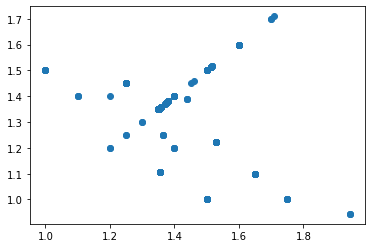

In [75]:
plt.scatter(df["m1"], df["m2"])

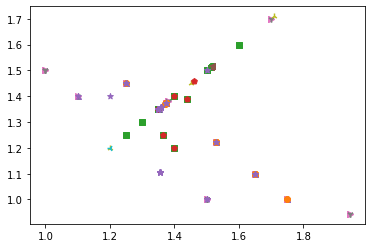

In [89]:
from matplotlib import markers as m
from matplotlib.lines import Line2D
for c,i in enumerate(set(np.array(df["eos"]))):
    tdf = df[df['eos'].str.contains(i)]
    plt.scatter(tdf["m1"], tdf["m2"],marker=list(Line2D.markers.items())[c][0])